In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from PIL import Image
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Concatenate, UpSampling2D, Add
from tensorflow.keras.layers import Convolution2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras import Input, Model

In [2]:
ins = []
outs = []
imDir = 'images'
labelDir = 'labels'

filt = '*'
#print(os.listdir(imDir))
files = [f for f in os.listdir(imDir) if re.match(r'.%s.jpg'%filt, f)]
print(files)


['1622419511952088.jpg', '1622419506502318.jpg', '1622419528268973.jpg', '1622419576046052.jpg', '1622419527177214.jpg', '1622419614871980.jpg', '1622419533705117.jpg', '1622419514156086.jpg', '1622419530437773.jpg', '1622419531525838.jpg', '1622419505408716.jpg', '1622419613773041.jpg', '1622419612683097.jpg', '1622419523935783.jpg', '1622419518489591.jpg', '1622419509784848.jpg', '1622419532613964.jpg', '1622419610516969.jpg', '1622419520677765.jpg', '1622419519582132.jpg', '1622419507617507.jpg']


In [3]:
ins = []
outs = []
for f in files:
    imFile = imDir + '/' + f
    labFile = labelDir + '/' + f
    
    im = Image.open(imFile)
    ins.append(np.asarray(im))
    
    label = Image.open(labFile)
    label = np.asarray(label)
    outs.append(np.where(label > 100, 1, 0))
    
sh = ins[0].shape
newSh = (1, sh[0], sh[1], sh[2])
ins = [np.reshape(i, newshape = newSh) for i in ins]
ins = np.concatenate(ins, axis=0)

sh = outs[0].shape
newSh = (1, sh[0], sh[1])
outs = [np.reshape(o, newshape = newSh) for o in outs]
outs = np.concatenate(outs, axis=0)

In [4]:
def createModel(inputShape):
    inputTensor = Input(shape = inputShape, name = 'input')
    
    tensors = []
    previousTensor = inputTensor
    count = 0
    
    tensors.append(Convolution2D(
            filters = 20,
            kernel_size = 3,
            strides = 3,
            padding = 'same',
            activation = 'elu',
            name = '1')(previousTensor))
    previousTensor = tensors[0]
    
    tensors.append(Convolution2D(
            filters = 40,
            kernel_size = 3,
            strides = 4,
            padding = 'same',
            activation = 'elu',
            name = '2')(previousTensor))
    previousTensor = tensors[1]
        
    tensors.append(Convolution2D(
            filters = 60,
            kernel_size = 3,
            strides = 2,
            padding = 'same',
            activation = 'elu',
            name = '3')(previousTensor))
    previousTensor = tensors[2]
    
    previousTensor = UpSampling2D(size = 24)(previousTensor)
    
    outputTensor = Convolution2D(2,
                            kernel_size = (1,1),
                            padding='same',
                            name = 'output',
                            activation='softmax')(previousTensor)
    
    #creates the model
    model = Model(inputs = inputTensor, outputs = outputTensor)
    
    #creates the optimizer
    opt = tf.keras.optimizers.Adam(lr=.0001, beta_1=.9, beta_2=.999, epsilon=None, decay=0.0, amsgrad=False)
    
    #compiles, prints and returns the model
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt,
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    print(model.summary())
    return model
    

In [5]:
print(ins.shape)
print(outs.shape)

(21, 1080, 1920, 3)
(21, 1080, 1920)


In [6]:
model = createModel(ins.shape[1:4])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1080, 1920, 3)]   0         
_________________________________________________________________
1 (Conv2D)                   (None, 360, 640, 20)      560       
_________________________________________________________________
2 (Conv2D)                   (None, 90, 160, 40)       7240      
_________________________________________________________________
3 (Conv2D)                   (None, 45, 80, 60)        21660     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 1080, 1920, 60)    0         
_________________________________________________________________
output (Conv2D)              (None, 1080, 1920, 2)     122       
Total params: 29,582
Trainable params: 29,582
Non-trainable params: 0
__________________________________________________

In [7]:
def training_set_generator_images(ins, outs, batch_size=10,
                          input_name='input', 
                        output_name='output'):
    '''
    Generator for producing random minibatches of image training samples.
    
    @param ins Full set of training set inputs (examples x row x col x chan)
    @param outs Corresponding set of sample (examples x nclasses)
    @param batch_size Number of samples for each minibatch
    @param input_name Name of the model layer that is used for the input of the model
    @param output_name Name of the model layer that is used for the output of the model
    '''
    
    while True:
        # Randomly select a set of example indices
        example_indices = random.choices(range(ins.shape[0]), k=batch_size)
        
        # The generator will produce a pair of return values: one for inputs and one for outputs
        yield({input_name: ins[example_indices,:,:,:]},
             {output_name: outs[example_indices,:,:]})
        
generator = training_set_generator_images(ins, outs, batch_size=10)


In [8]:
history = model.fit(x=ins, y=outs, epochs=100, steps_per_epoch = 2, verbose=True)

Epoch 1/100
2/2 [==============================] - 5s 3s/step - loss: 2.6522 - sparse_categorical_accuracy: 0.6645
Epoch 2/100
2/2 [==============================] - 5s 3s/step - loss: 1.5374 - sparse_categorical_accuracy: 0.7675
Epoch 3/100
2/2 [==============================] - 5s 3s/step - loss: 0.8021 - sparse_categorical_accuracy: 0.8569
Epoch 4/100
2/2 [==============================] - 5s 3s/step - loss: 0.4305 - sparse_categorical_accuracy: 0.9198
Epoch 5/100
2/2 [==============================] - 5s 3s/step - loss: 0.2556 - sparse_categorical_accuracy: 0.9547
Epoch 6/100
2/2 [==============================] - 6s 3s/step - loss: 0.1720 - sparse_categorical_accuracy: 0.9703
Epoch 7/100
2/2 [==============================] - 5s 3s/step - loss: 0.1280 - sparse_categorical_accuracy: 0.9793
Epoch 8/100
2/2 [==============================] - 5s 3s/step - loss: 0.1037 - sparse_categorical_accuracy: 0.9846
Epoch 9/100
2/2 [==============================] - 6s 3s/step - loss: 0.0892 - s

In [12]:
pred = model.predict(ins)

In [13]:
labels=np.argmax(pred, axis=3)

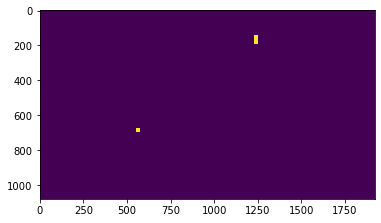

In [30]:
plt.imshow(labels[10,:,:])

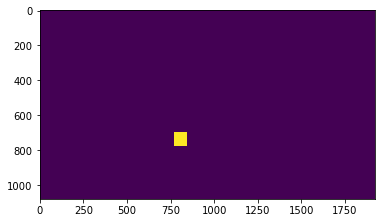

In [26]:
plt.imshow(outs[7,:,:])

In [ ]:
plt.imshow(ins[4,:,:])

In [27]:
model.save('testModel')

INFO:tensorflow:Assets written to: testModel/assets


AttributeError: module 'tensorflow._api.v2.train' has no attribute 'Saver'